In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input, EfficientNetB0
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.applications import VGG16
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path = "./garbage_classification/"

categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [3]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [4]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,category
0,clothes/clothes2811.jpg,clothes
1,battery/battery147.jpg,battery
2,clothes/clothes4237.jpg,clothes
3,biological/biological520.jpg,biological
4,plastic/plastic354.jpg,plastic


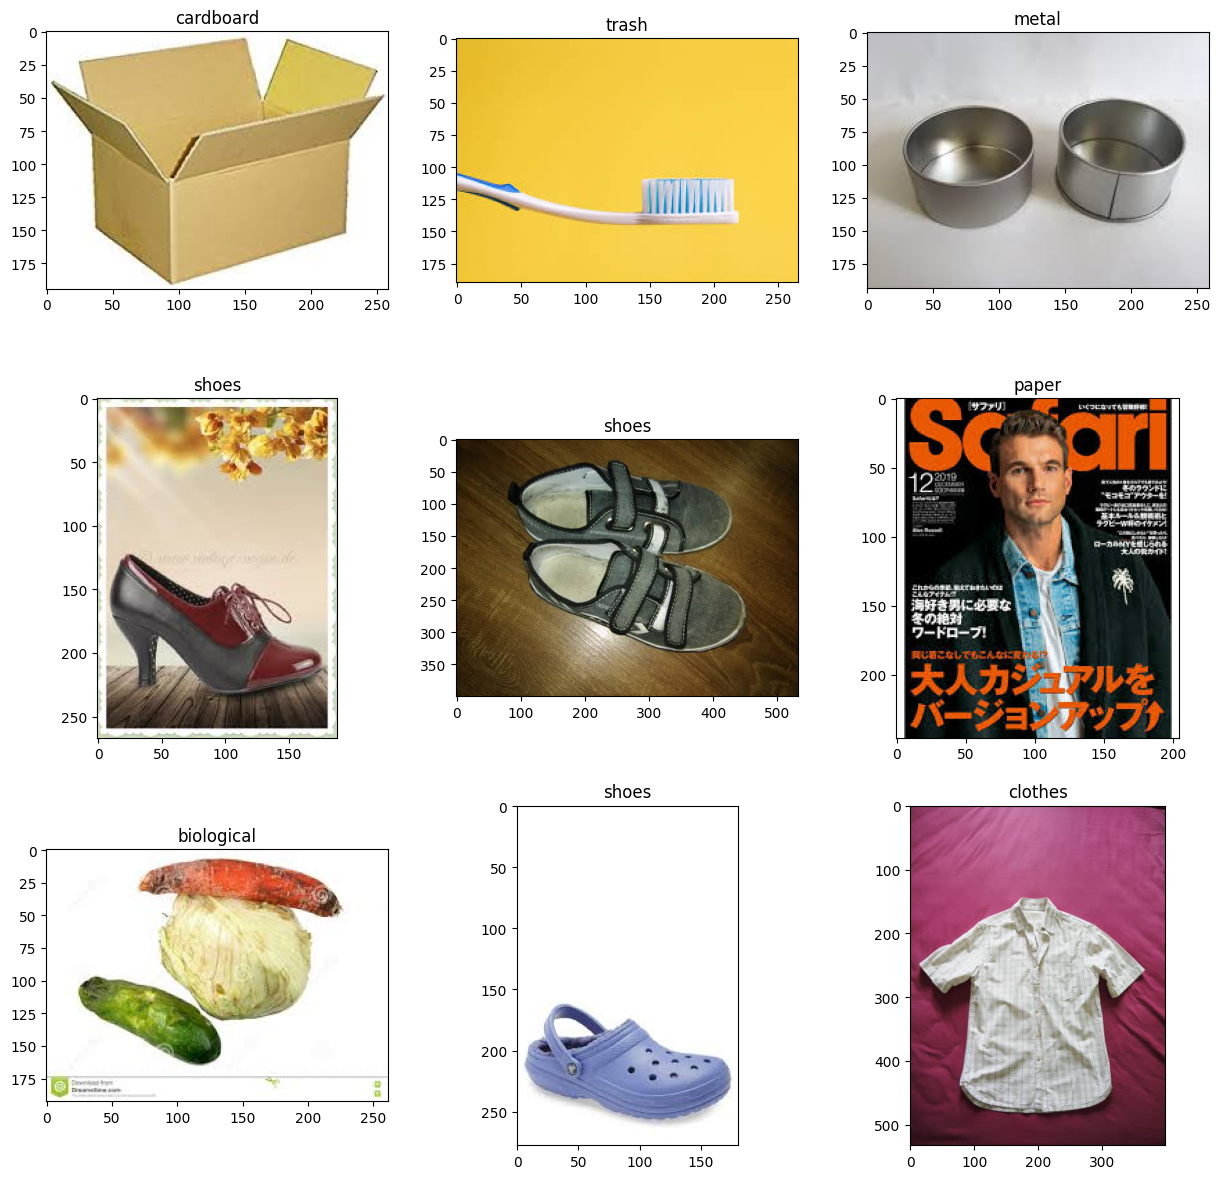

In [5]:

plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

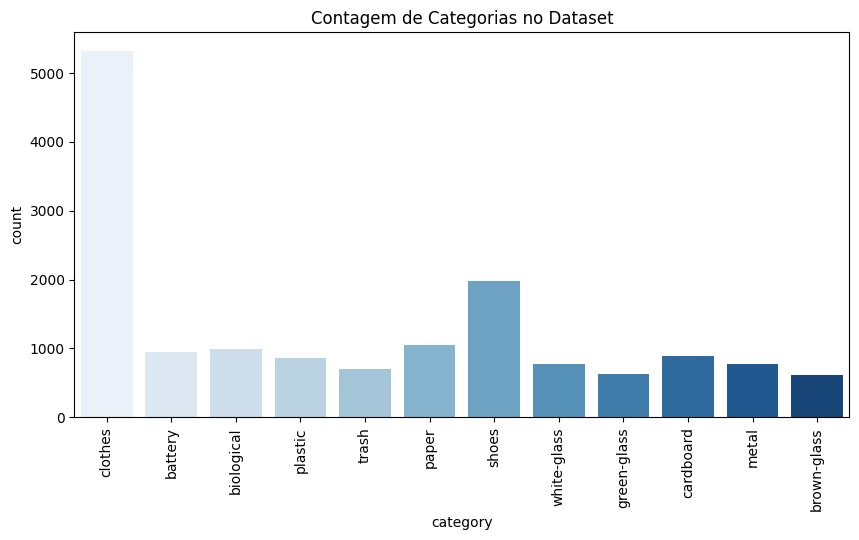

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Contagem de Categorias no Dataset')
plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [9]:
train_df.head()

,filename,category
0,shoes/shoes321.jpg,shoes
1,trash/trash83.jpg,trash
2,battery/battery107.jpg,battery
3,clothes/clothes1071.jpg,clothes
4,metal/metal69.jpg,metal


In [10]:
im_shape = (224, 224)
batch_size = 64
seed = 42

In [11]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.


In [13]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [14]:
vgg_layer = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(im_shape[0], im_shape[1], 3))

vgg_layer.trainable = False

model = Sequential()
model.add(tf.keras.Input(shape=(im_shape[0], im_shape[1], 3)))

def vgg_preprocessing(img):
    return tf.keras.applications.vgg16.preprocess_input(img)

model.add(Lambda(vgg_preprocessing))

model.add(vgg_layer)

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block6_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block6_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block6_conv3'))

model.add(Dropout(rate=0.5))

model.add(Flatten())
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(rate=0.5))
model.add(Dense(4096, activation='relu',  name='fc2'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='softmax', name='predictions'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 block6_conv1 (Conv2D)       (None, 7, 7, 512)         2359808   
                                                                 
 block6_conv2 (Conv2D)       (None, 7, 7, 512)         2359808   
                                                                 
 block6_conv3 (Conv2D)       (None, 7, 7, 512)         2359808   
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0

In [15]:
%%time
epochs = 100

#Callback to save the best model
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
193/193 [==============================] - 30s 125ms/step - loss: 2.2321 - accuracy: 0.3373 - val_loss: 2.1927 - val_accuracy: 0.3431
Epoch 2/100
193/193 [==============================] - 21s 107ms/step - loss: 2.1909 - accuracy: 0.3441 - val_loss: 2.1891 - val_accuracy: 0.3431
Epoch 3/100
193/193 [==============================] - 21s 107ms/step - loss: 2.1453 - accuracy: 0.3469 - val_loss: 2.0552 - val_accuracy: 0.3581
Epoch 4/100
193/193 [==============================] - 21s 106ms/step - loss: 1.9823 - accuracy: 0.3759 - val_loss: 1.9279 - val_accuracy: 0.4076
Epoch 5/100
193/193 [==============================] - 21s 108ms/step - loss: 1.8636 - accuracy: 0.4019 - val_loss: 1.8951 - val_accuracy: 0.3815
Epoch 6/100
193/193 [==============================] - 21s 106ms/step - loss: 1.8030 - accuracy: 0.4203 - val_loss: 1.7429 - val_accuracy: 0.4447
Epoch 7/100
193/193 [==============================] - 21s 107ms/step - loss: 1.7164 - accuracy: 0.4456 - val_loss: 1.6487 -

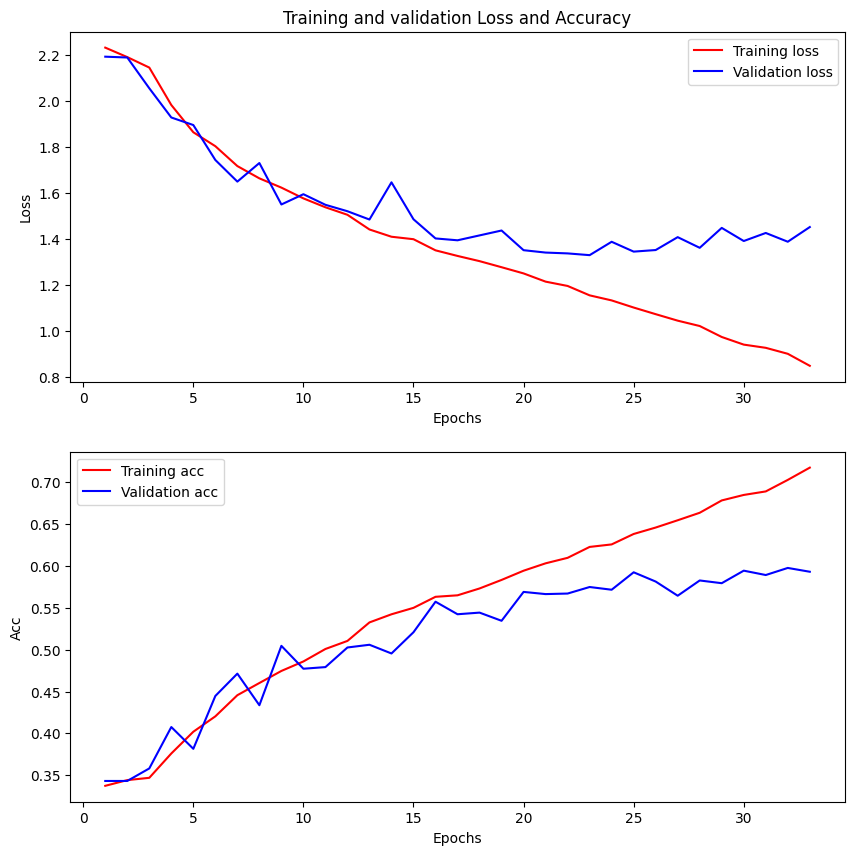

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [17]:
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 3s 129ms/step - loss: 1.4570 - accuracy: 0.5925
Val loss: 1.4569581747055054
Val accuracy: 0.5925209522247314


In [18]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1552/1552 [==============================] - 8s 5ms/step - loss: 1.5007 - accuracy: 0.5825
Test loss: 1.5007086992263794
Test accuracy: 0.5824742317199707


1552/1552 [==============================] - 7s 4ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.63      0.61      0.62       112
  biological       0.59      0.48      0.53        98
 brown-glass       0.38      0.28      0.32        64
   cardboard       0.44      0.51      0.47        82
     clothes       0.77      0.91      0.83       520
 green-glass       0.34      0.16      0.22        75
       metal       0.42      0.18      0.25        71
       paper       0.52      0.38      0.44       103
     plastic       0.31      0.25      0.28        71
       shoes       0.58      0.48      0.52       210
       trash       0.38      0.49      0.42        68
 white-glass       0.29      0.53      0.37        78

    accuracy                           0.58      1552
   macro avg       0.47      0.44      0.44      1552
weighted avg       0.57      0.58      0.57      1552



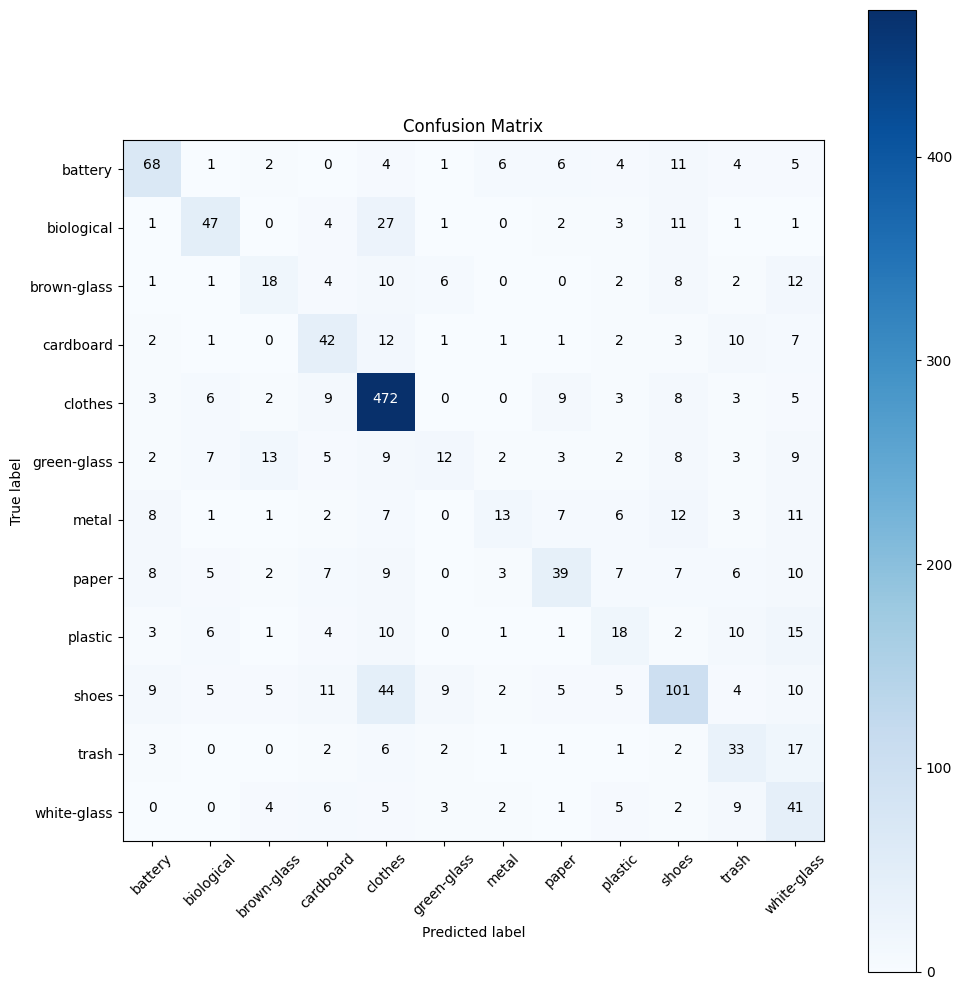

In [19]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))